# Pipeline for High-z Radio Galaxies 09: Redshift prediction

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC).  

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [22]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [23]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'radio_detect'] == 1)]

In [24]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
# n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 9,894 elements,
9,894 of them are marked as AGN, and 9,894 are identified as radio detections.


---

## Possible correlations

In [25]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [26]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [27]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [28]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'radio_detect', 'zsp'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [29]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [30]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [31]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [32]:
# train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
#                                                 random_state=seed, stratify=None)
train_test_df = full_catalog_df.loc[np.isfinite(full_catalog_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
validation_df = full_catalog_df.drop(train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (9894, 41)
Data for Modeling (Train and Test): (7378, 41)
Unseen Data For Validation: (2516, 41)
----------------------------------------


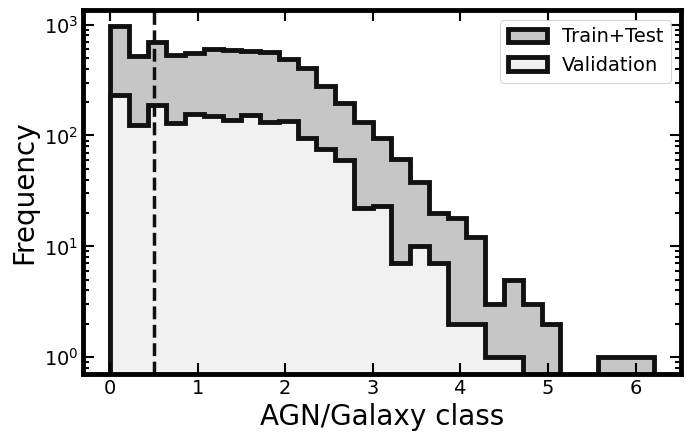

In [74]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [33]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [34]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [35]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [36]:
rsd_vals

z_y         293.628134
i_z         248.862801
w1_w2       142.595782
r_i         137.807111
g_r         114.533252
g_i          95.155998
Z            68.564875
w2_w3        39.745430
J_H          33.734859
H_K          33.482413
w3_w4        26.145066
band_num     17.847236
W1mproPM      7.035701
W1mag         6.785498
gmag          6.727800
W2mproPM      6.716949
ymag          6.614726
rmag          6.599939
imag          6.551117
W2mag         6.501412
zmag          6.440327
g/J           5.807647
w1/w4         5.799214
i/K           5.608929
r/H           5.444514
w2/w4         5.435181
W3mag         4.766531
w1/w3         4.310774
y/W2          4.059395
z/W1          3.889758
NUVmag        3.193380
W4mag         3.121673
Hmag          3.041192
Jmag          2.951408
FUV/K         2.464352
i/y           2.350149
r/z           2.293483
Kmag          2.207396
FUVmag        1.299736
J/K           1.078631
FUV_NUV     -67.090654
dtype: float64

In [37]:
correlation = norm_train_test_df.corr()

In [38]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [39]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [40]:
target_feat = 'Z'

In [41]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [42]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [43]:
list_drop_corr

['Jmag',
 'W2mag',
 'W1mag',
 'Kmag',
 'imag',
 'W2mproPM',
 'zmag',
 'rmag',
 'w2/w4',
 'FUV_NUV',
 'r/H',
 'J/K',
 'w1/w3',
 'g/J',
 'w1/w4',
 'i/K',
 'Hmag',
 'W3mag',
 'ymag',
 'g_i',
 'W1mproPM']

In [44]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [45]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [46]:
corr_discard = norm_train_test_discard.corr()

In [47]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
NUVmag    FUVmag      0.689168
y/W2      z/W1        0.678066
z_y       i/y         0.663246
band_num  gmag        0.663238
r/z       r_i         0.624431
i_z       r/z         0.613812
gmag      w3_w4       0.599837
w3_w4     band_num    0.592782
w2_w3     gmag        0.572284
band_num  w2_w3       0.560118
H_K       FUV/K       0.556131
band_num  H_K         0.541649
NUVmag    gmag        0.541274
z/W1      Z           0.518311
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

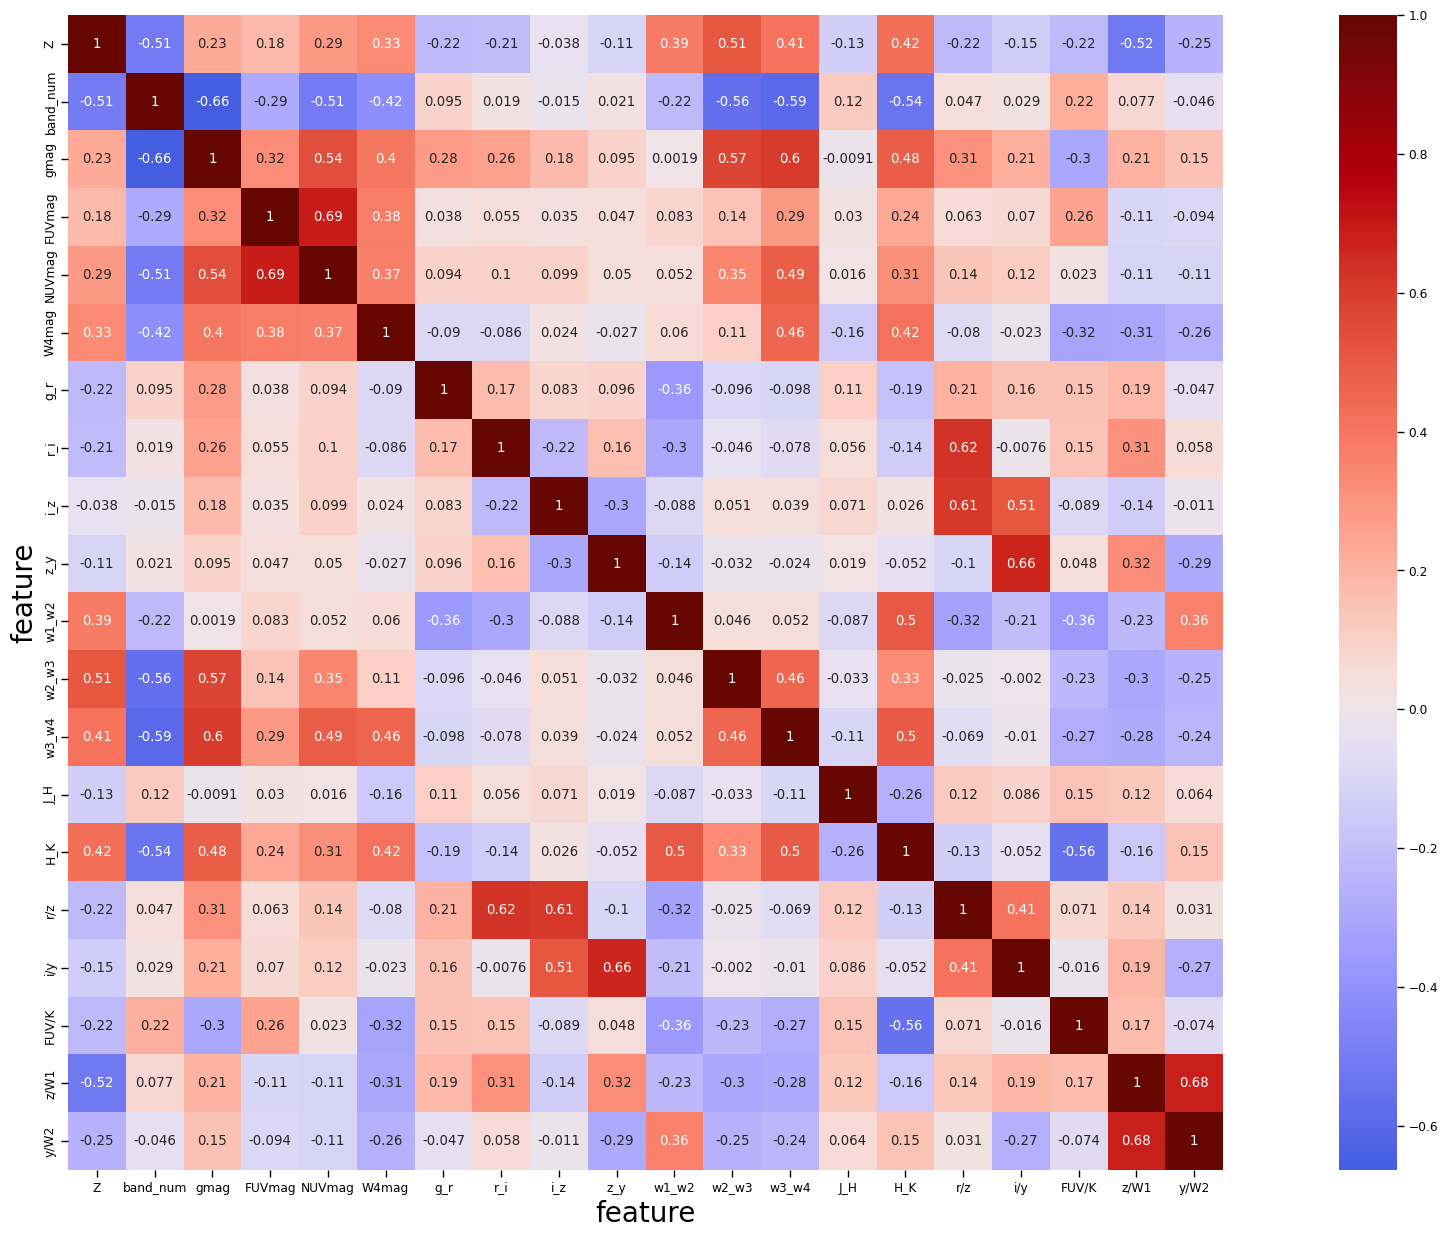

In [48]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [49]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [50]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [51]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
Z         H_K         0.385940
FUV/K     FUVmag      0.358059
J_H       H_K         0.343173
band_num  gmag        0.310201
J_H       band_num    0.281732
NUVmag    FUVmag      0.278596
H_K       band_num    0.259071
FUV/K     H_K         0.245685
band_num  w3_w4       0.226094
          w2_w3       0.211196
FUV/K     band_num    0.205903
band_num  H_K         0.204477
          Z           0.203584
          NUVmag      0.191753
NUVmag    band_num    0.186091
W4mag     w3_w4       0.178814
NUVmag    gmag        0.164389
H_K       Z           0.146242
FUV/K     gmag        0.142083
dtype: float64

In [52]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [53]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [54]:
target_feat = 'Z'

In [55]:
list_drop_pps = []

In [56]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [57]:
list_drop_pps

[]

In [58]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [59]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [60]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.203584,regression,True,mean absolute error,0.117021,0.093197,DecisionTreeRegressor()
1,H_K,Z,0.146242,regression,True,mean absolute error,0.117021,0.099908,DecisionTreeRegressor()
2,J_H,Z,0.140102,regression,True,mean absolute error,0.117021,0.100626,DecisionTreeRegressor()
3,FUV/K,Z,0.133105,regression,True,mean absolute error,0.117021,0.101445,DecisionTreeRegressor()
4,W4mag,Z,0.080363,regression,True,mean absolute error,0.117021,0.107617,DecisionTreeRegressor()
5,FUVmag,Z,0.030661,regression,True,mean absolute error,0.117021,0.113433,DecisionTreeRegressor()
6,w3_w4,Z,0.015964,regression,True,mean absolute error,0.117021,0.115153,DecisionTreeRegressor()
7,NUVmag,Z,0.006464,regression,True,mean absolute error,0.117021,0.116265,DecisionTreeRegressor()
8,z/W1,Z,0.001295,regression,True,mean absolute error,0.117021,0.116869,DecisionTreeRegressor()
9,gmag,Z,0.000000,regression,True,mean absolute error,0.117021,0.150046,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [61]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('FUV/K')  # After Boruta
final_feats.remove('W4mag')  # After Boruta
final_feats.remove('FUVmag')  # After Boruta

In [62]:
feats_2_discard = list_drop_corr + list_drop_pps + ['FUV/K', 'W4mag', 'FUVmag']

Boruta discards one feature.

In [63]:
exp_radio = pyr.setup(data=train_test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(7378, 41)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5164, 16)"


In [64]:
pyr.get_config('X').columns

Index(['band_num', 'gmag', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2',
       'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y', 'z/W1', 'y/W2'],
      dtype='object')

In [65]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [66]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fa0347a1820>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [67]:
models_reg_gpu       = ['catboost', 'xgboost', 'lightgbm', 'dummy', 'lr', 'knn', 'ridge', 'rf']  # knn too slow, ridge does not work
final_selection_reg  = ['rf', 'et', 'dt', 'catboost', 'xgboost', 'dummy']  # knn discarded: no feature importances
n_models             = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='s_nmad')  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, sort='s_nmad')  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2682,0.2169,0.4645,0.7181,0.1937,0.4904,0.1964,0.0889,0.4645,0.2285,0.2419,0.5010
et,Extra Trees Regressor,0.2660,0.2037,0.4502,0.7353,0.1869,0.4767,0.2063,0.0938,0.4502,0.2192,0.2423,0.2480
dt,Decision Tree Regressor,0.3530,0.3859,0.6203,0.4961,0.2540,0.5221,0.2402,0.1082,0.6203,0.3032,0.3011,0.0170
catboost,CatBoost Regressor,0.2776,0.2045,0.4509,0.7343,0.1883,0.5586,0.2368,0.1159,0.4509,0.2191,0.2552,0.5360
xgboost,Extreme Gradient Boosting,0.2945,0.2309,0.4792,0.6995,0.2003,0.5598,0.2513,0.1175,0.4792,0.2322,0.2781,9.0080
dummy,Dummy Regressor,0.7256,0.7705,0.8774,-0.0025,0.4041,2.8720,1.0177,0.4215,0.8774,0.5016,0.7372,0.0100


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [68]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2473,0.1922,0.4384,0.7524,0.1904,0.4357,0.1588,0.0781,0.4384,0.2292,0.1973
1,0.2360,0.2001,0.4473,0.7642,0.1749,0.3577,0.1589,0.0699,0.4473,0.2017,0.1760
2,0.2587,0.2549,0.5049,0.6804,0.2009,0.4766,0.1805,0.0802,0.5049,0.2716,0.2050
3,0.2353,0.1664,0.4079,0.7580,0.1744,0.4075,0.1787,0.0838,0.4079,0.1948,0.1954
4,0.2771,0.2299,0.4795,0.6899,0.1978,0.4370,0.1917,0.0867,0.4795,0.2347,0.2306
5,0.2541,0.1966,0.4434,0.7485,0.1762,0.3884,0.1947,0.0828,0.4434,0.1918,0.2035
6,0.2447,0.1702,0.4125,0.7805,0.1725,0.5088,0.1648,0.0760,0.4125,0.2012,0.2306
7,0.2788,0.2537,0.5037,0.6839,0.2109,0.5071,0.1815,0.0756,0.5037,0.2739,0.2209
8,0.2350,0.1674,0.4091,0.7721,0.1669,0.3576,0.1599,0.0718,0.4091,0.1875,0.1860


In [69]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize='s_nmad',\
                               search_library='tune-sklearn', search_algorithm='random')  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2457,0.1804,0.4247,0.7676,0.1825,0.4286,0.1614,0.0862,0.4247,0.2055,0.1896
1,0.2446,0.2249,0.4742,0.7350,0.1766,0.3593,0.1615,0.0719,0.4742,0.1865,0.1876
2,0.2449,0.2135,0.4620,0.7323,0.1805,0.4272,0.1798,0.0831,0.4620,0.2215,0.1934
3,0.2431,0.1745,0.4177,0.7462,0.1752,0.4573,0.1902,0.0980,0.4177,0.1932,0.1954
4,0.2779,0.2251,0.4744,0.6965,0.1947,0.4004,0.2111,0.0935,0.4744,0.2134,0.2171
5,0.2631,0.2039,0.4515,0.7392,0.1785,0.3936,0.2089,0.0894,0.4515,0.1898,0.2229
6,0.2353,0.1544,0.3929,0.8009,0.1597,0.4046,0.1777,0.0861,0.3929,0.1786,0.2209
7,0.2774,0.2472,0.4972,0.6919,0.2071,0.4946,0.1824,0.0856,0.4972,0.2591,0.2151
8,0.2364,0.1514,0.3891,0.7939,0.1569,0.3952,0.1917,0.0847,0.3891,0.1689,0.1938


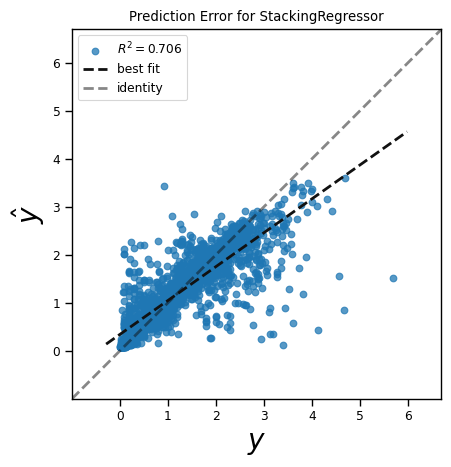

In [70]:
pyr.plot_model(tuned_z_reg, plot='error')

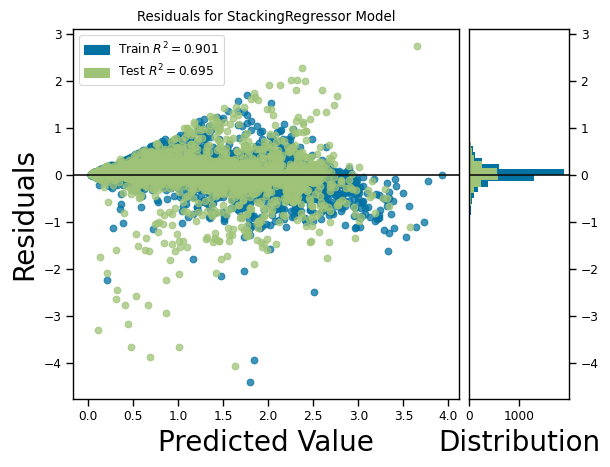

In [71]:
pyr.plot_model(tuned_z_reg, plot='residuals')

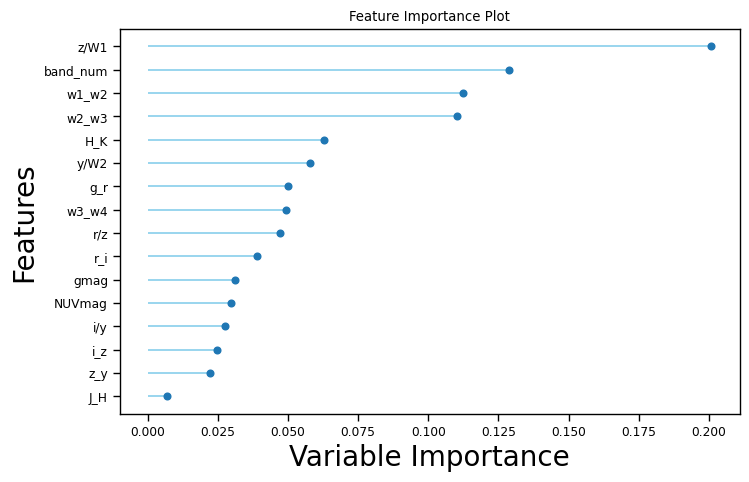

In [75]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [76]:
pyr.plot_model(tuned_z_reg, plot='parameter')

,Parameters
cv,5
estimators,"[('et', ExtraTreesRegressor(bootstrap=False, c..."
final_estimator,"RandomForestRegressor(bootstrap=True, ccp_alph..."
n_jobs,12
passthrough,True
verbose,0


In [77]:
plt.rcParams.update(plt.rcParamsDefault)

In [78]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2686,0.2319,0.4816,0.7065,0.1938,0.4394,0.1888,0.0895,0.4816,0.2097,0.2123


,band_num,gmag,NUVmag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,w3_w4,J_H,H_K,r/z,i/y,z/W1,y/W2,Z,Label
0,1.434086,-1.175063,0.530496,0.698837,0.418604,0.058509,-0.210447,-1.753921,-1.313839,0.825084,-0.748405,-2.231115,0.478783,-0.074476,-1.263713,-2.260960,0.108,0.123150
1,1.434086,-2.470646,-2.099795,1.061754,-0.321601,0.739999,-0.627324,-1.952054,-2.462090,-1.626020,-0.748405,-2.248414,0.603117,0.132834,1.414290,0.351742,0.006,0.092825
2,-0.890483,1.120248,0.530496,-0.795143,0.249169,0.791812,-1.501698,0.237292,0.760479,0.825084,-0.055633,0.327552,0.594956,-0.768698,0.409681,1.195728,1.897,1.732681
3,0.049185,0.642453,0.530496,-0.762188,0.361247,0.225280,0.305067,-0.977012,0.215955,-0.921378,-0.055633,0.327552,0.339269,0.399735,1.584498,1.000401,0.709,0.672794
4,1.891434,-0.824121,-0.910705,0.359352,0.242213,1.104004,-0.962594,-0.949218,-0.912552,-1.418043,-0.041860,-2.088074,1.081734,-0.063218,-0.027011,0.051825,0.149,0.133181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,-0.419048,0.011310,0.530496,0.439763,0.509086,0.485887,-0.055641,-1.073358,-1.040308,0.825084,-0.055633,0.327552,0.737361,0.327557,0.504979,-0.027481,0.400,0.448744
2210,-0.419048,-1.054006,0.530496,-0.499699,-0.134730,-0.126711,-0.355078,0.555382,-0.466837,-0.645347,-0.055633,0.327552,-0.172900,-0.381567,-1.754658,-1.022789,1.641,2.076856
2211,1.434086,-0.128814,0.530496,0.994874,0.852089,1.273162,-0.292443,-0.810681,0.176802,-1.348083,3.493783,-2.215276,1.684323,0.707699,-0.002744,-0.224493,0.259,0.161494
2212,0.513548,1.263002,0.530496,1.419819,0.301323,0.976116,1.227915,-1.628219,1.622329,0.825084,-0.055633,0.327552,0.820398,1.824703,-0.542005,-2.214876,0.371,0.531469


In [79]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2686,0.2319,0.4816,0.7065,0.1938,0.4394,0.1888,0.0895,0.4816,0.2097,0.2123


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [80]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost

In [81]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_may_06_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('models/config_regression_z_may_06_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_may_06_2022')

### Prediction process

#### Feature importances

In [82]:
estimators_list = [estimator[0] for estimator in final_z_reg.estimators]

In [83]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [84]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [85]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [86]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [87]:
base_models_names = [model[0] for model in estimators_list]

In [88]:
coef_sorted_base_df = {}

In [89]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [90]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [91]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for dt...
Calculating for catboost...
Calculating for xgboost...


et                   dt             catboost              xgboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       z/W1  20.279832      z/W1  33.746556      z/W1  23.555569      z/W1   
1   band_num  12.398655  band_num  18.672337     w1_w2  12.257979  band_num   
2      w1_w2  11.512608     w1_w2  10.703962  band_num  11.781328       H_K   
3      w2_w3  11.287535     w2_w3   7.837781       g_r   8.595557     w1_w2   
4       y/W2   6.289226       g_r   6.261611     w2_w3   8.583340     w2_w3   
5        g_r   5.384847       r/z   4.355851       r/z   6.894286      y/W2   
6        H_K   5.308805      y/W2   4.154030      y/W2   5.340428       r/z   
7        r/z   4.938675       i_z   3.182176       r_i   3.873205       g_r   
8      w3_w4   4.705156       r_i   2.973017      gmag   3.233968     w3_w4   
9        r_i   3.575558       z_y   2.173906       z_y   3.110139       i/y   
10      gmag   3.112397      gmag   2.105906       i/y   3.067177       r_i   
11    NUVmag   3.043721       i/y   1.790742       H_K   3.059624    NUVmag   
12       i/y   2.722436     w3_w4   1.066117       i_z   2.984285       i_z   
13       i_z   2.480274       H_K   0.773825     w3_w4   2.437155       J_H   
14       z_y   2.396788    NUVmag   0.104674    NUVmag   0.921152       z_y   
15       J_H   0.563488       J_H   0.097508       J_H   0.304807      gmag   

               
   Importance  
0   31.987440  
1   17.074871  
2    9.933799  
3    7.779820  
4    5.507777  
5    3.776599  
6    3.757707  
7    3.554381  
8    3.088722  
9    2.388377  
10   2.165961  
11   2.107486  
12   2.060167  
13   1.691836  
14   1.648716  
15   1.476334

In [92]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,xgboost,28.247705
1,dt,21.505658
2,et,16.780605
3,catboost,8.599013
4,z/W1,5.002015
5,H_K,4.108337
6,band_num,2.888129
7,w1_w2,2.665000
8,g_r,1.979130
9,y/W2,1.645327


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
z/W1	23.705
w1_w2	12.192
band_num	11.906
w2_w3	8.572
g_r	8.493
r/z	6.820
y/W2	5.323
r_i	3.845
gmag	3.205
H_K	3.126
z_y	3.080
i/y	3.045
i_z	2.972
w3_w4	2.452
NUVmag	0.945
J_H	0.319


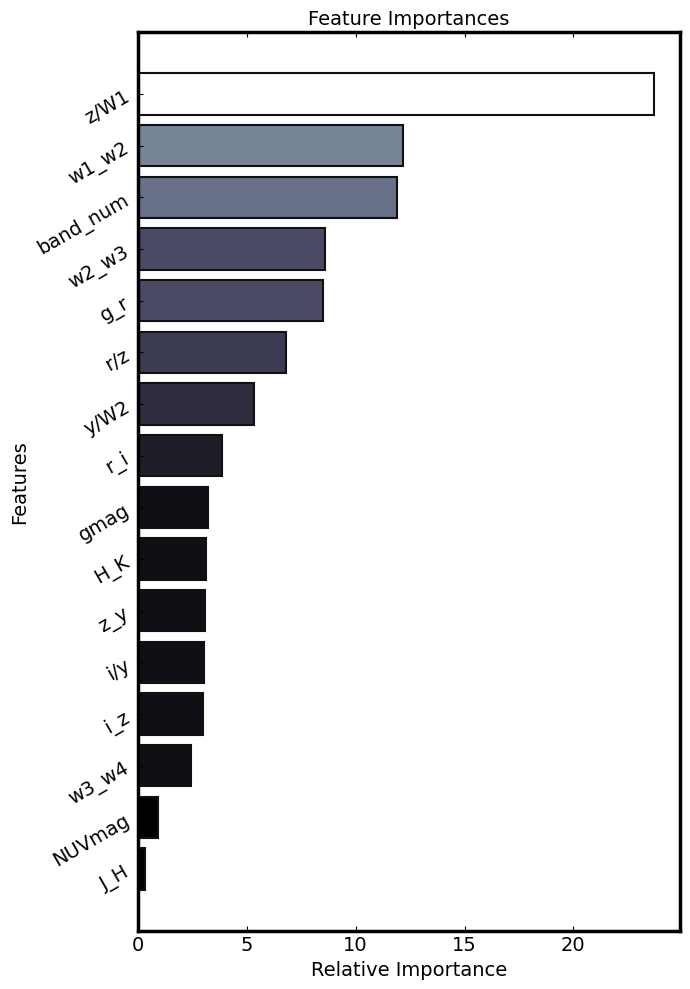

In [93]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_01.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [101]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0,0,0,0,0,0,0.1686,0.0779,0.3572,0.1648,0.1913


In [102]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,1845.000000,2516.000000
mean,1.274458,1.300649
std,0.856363,0.727072
min,0.003000,0.083194
25%,0.519000,0.714134
50%,1.211000,1.265809
75%,1.900000,1.833147
max,4.610000,3.448981


/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost

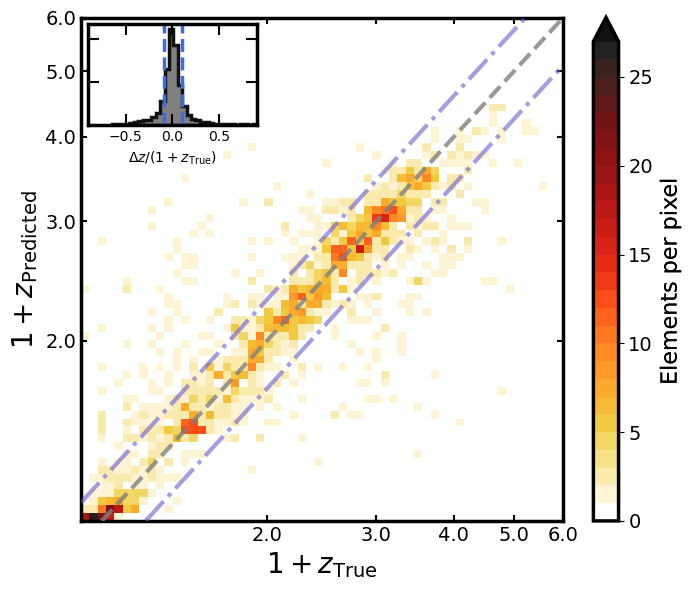

In [115]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
norm = ImageNormalize(vmin=0.)

filt_pair_z = np.isfinite(validation_prediction_reg.loc[:, 'Z']) & np.isfinite(validation_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + validation_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + validation_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', 27), zorder=0, dpi=13, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (validation_prediction_reg.loc[:, 'Label'] - validation_prediction_reg.loc[:, 'Z']) / (1 + validation_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=-0.3, right=np.ceil(max_for_range))
ax1.set_ylim(bottom=-0.3, top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_01.pdf', bbox_inches='tight')
plt.show()

In [116]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['Z']),
                train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [117]:
train_prediction_reg = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg  = pyr.predict_model(final_z_reg, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1064,0.0357,0.1889,0.9537,0.0701,0.1966,0.0879,0.0428,0.1889,0.0714,0.0449


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1147,0.0424,0.2059,0.9463,0.0764,0.2099,0.0947,0.0435,0.2059,0.0777,0.0574


In [120]:
sigma_mad_train    = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test     = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid    = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [121]:
sigma_nmad_train   = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test    = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid   = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [122]:
sigma_z_train      = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test       = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_valid      = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [123]:
sigma_z_norm_train = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test  = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [124]:
out_frac_train     = outlier_frac(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
out_frac_test      = outlier_frac(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
out_frac_valid     = outlier_frac(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [129]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0879
Sigma NMAD:		0.0428
Sigma z:		0.1889
Sigma z norm:		0.0714
Out fraction:		0.0449
-----------------------------------


In [130]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.0947
Sigma NMAD:		0.0435
Sigma z:		0.2059
Sigma z norm:		0.0777
Out fraction:		0.0574
-----------------------------------


In [131]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.1686
Sigma NMAD:		0.0779
Sigma z:		0.3572
Sigma z norm:		0.1648
Out fraction:		0.1913
-----------------------------------


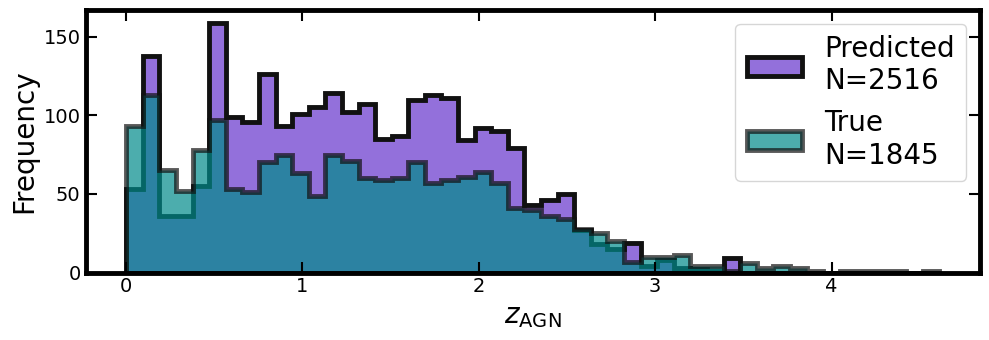

In [139]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_01.pdf')
plt.show()